In [334]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import os
import matplotlib.pyplot as plt
import cv2


In [335]:
# face bounder indices
FACE_OVAL=[ 10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103,67, 109]

# lips indices for Landmarks
LIPS=[ 61, 146, 91, 181, 84, 17, 314, 405, 321, 375,291, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95,185, 40, 39, 37,0 ,267 ,269 ,270 ,409, 415, 310, 311, 312, 13, 82, 81, 42, 183, 78 ]
LOWER_LIPS =[61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95]
UPPER_LIPS=[ 185, 40, 39, 37,0 ,267 ,269 ,270 ,409, 415, 310, 311, 312, 13, 82, 81, 42, 183, 78]
# Left eyes indices
LEFT_EYE =[ 362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385,384, 398 ]
LEFT_EYEBROW =[ 336, 296, 334, 293, 300, 276, 283, 282, 295, 285 ]

# right eyes indices
RIGHT_EYE=[ 33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161 , 246 ]
RIGHT_EYEBROW=[ 70, 63, 105, 66, 107, 55, 65, 52, 53, 46 ]

In [336]:
import glob
PATH = "/Users/raminduwalgama/Documents/Projects/OneID/icao-guidelines-server/detectors/eye/"

all_images = glob.glob("../../dataset/valid/*.JPG")

## Plot contours

In [386]:
def plot_contours(contours):
    # Calculate the number of rows and columns needed for the subplot
    n = len(contours)
    ncols = int(np.ceil(np.sqrt(n)))
    nrows = int(np.ceil(n / ncols))

    # Create a figure for subplots
    plt.figure(figsize=(5 * ncols, 5 * nrows))

    # Create a black image with same dimensions as original image for final plot
    final_image = np.zeros(left_iris.shape, np.uint8)
    j = 0
    for i, contour in enumerate(contours):
        # Create a black image with same dimensions as original image
        black_image = np.zeros(left_iris.shape, np.uint8)

        # Draw the contour on the black image and fill it with white color
        cv2.drawContours(black_image, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)

        # Add the image with contour to the subplot
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(black_image)
        plt.title(f'Contour {i+1}')
        j += 1
        # Draw the contour on the final image
        cv2.drawContours(final_image, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)

    try:
        # Add the final image to the subplot
        plt.subplot(nrows, ncols, j + 1)
        plt.imshow(final_image)
    except ValueError:
        plt.show()
        plt.imshow(final_image)
    # Show the subplots
    plt.show()


## Get face Landmarks usnig media pipe

In [337]:
def get_face_landmarks(image_path):
    model_path = os.path.join(PATH, "../utilities/face_landmarker.task")
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.FaceLandmarkerOptions(
        base_options=base_options,
        output_face_blendshapes=True,
        output_facial_transformation_matrixes=True,
        num_faces=1,
    )
    detector = vision.FaceLandmarker.create_from_options(options)
    image = mp.Image.create_from_file(image_path)
    detection_result = detector.detect(image)
    face_landmarks_list = detection_result.face_landmarks
    face_landmarks = face_landmarks_list[0]
    return face_landmarks

In [338]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

def draw_landmarks_on_image(image_path):
    model_path = os.path.join(PATH, "../utilities/face_landmarker.task")
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.FaceLandmarkerOptions(
        base_options=base_options,
        output_face_blendshapes=True,
        output_facial_transformation_matrixes=True,
        num_faces=1,
    )
    detector = vision.FaceLandmarker.create_from_options(options)
    image = mp.Image.create_from_file(image_path)
    detection_result = detector.detect(image)



    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(image.numpy_view())

    # Loop through the detected faces to visualize.
    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]


    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

    return annotated_image

## Crop iris region

In [339]:
def crop_iris_region(image_path, landmarks, points, padding=0):
    image = cv2.imread(image_path)
    # image = np.rot90(image)
    height, width = image.shape[:2]
    x_coordinates = [int(landmarks[point].x * width) for point in points]
    y_coordinates = [int(landmarks[point].y * height) for point in points]
    x_min, x_max = min(x_coordinates), max(x_coordinates)
    y_min, y_max = min(y_coordinates), max(y_coordinates)
    cropped_image = image[y_min-padding:y_max+padding, x_min-padding:x_max+padding]
    return cropped_image


## Testing for an image

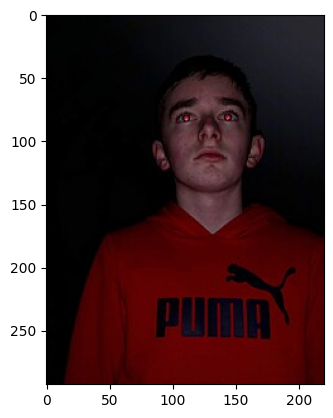

W20231002 21:15:45.924626 3378056 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.


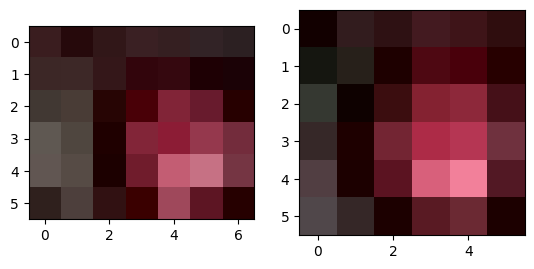

In [390]:
image_path = '/Users/raminduwalgama/Downloads/Red_eye_effect_2.jpg'
# image_path = '/Users/raminduwalgama/Downloads/Archive (1)/001831.jpg'
# image_path = '/Users/raminduwalgama/Documents/Projects/OneID/icao-guidelines-server/dataset/invalid/hair_cross.jpeg'
# image_path = '/Users/raminduwalgama/Documents/Projects/OneID/icao-guidelines-server/dataset/valid/N230101778.JPG'
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.show()
face_landmarks = get_face_landmarks(image_path)
LEFT_IRIS = list(set([index for pair in mp.solutions.face_mesh.FACEMESH_LEFT_IRIS for index in pair]))
RIGHT_IRIS = list(set([index for pair in mp.solutions.face_mesh.FACEMESH_RIGHT_IRIS for index in pair]))

left_iris = crop_iris_region(image_path=image_path,
                             landmarks=face_landmarks,
                             points=LEFT_IRIS,
                             padding=0)

right_iris = crop_iris_region(image_path=image_path,
                              landmarks=face_landmarks,
                              points=RIGHT_IRIS,
                              padding=0)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(left_iris, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(right_iris, cv2.COLOR_BGR2RGB))
plt.show()


W20231002 19:18:23.221349 3378056 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.


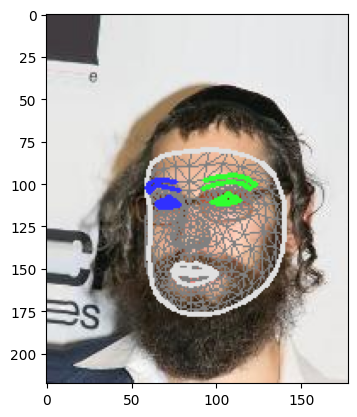

In [342]:
import numpy as np
annotated_image = draw_landmarks_on_image(image_path)
# annotated_image = np.rot90(annotated_image, 3)
plt.imshow(annotated_image)
plt.show()

# Red Eye detection

## Average color

In [397]:
# Calculate the average color of the image
average_color_per_row = np.average(left_iris, axis=0)
average_color = np.average(average_color_per_row, axis=0)

print(average_color)

# Split the average color into RGB components
blue, green, red = average_color
max_threshold = np.max(average_color[:1])
print(max_threshold)
# Check if the red component is significantly higher than the green and blue components
if red > max_threshold and red > max_threshold:
    print("Red eye detected.")
else:
    print("Red eye not detected.")

[40.33333333 34.95238095 78.52380952]
40.33333333333333
Red eye detected.


## Canny Edge with Contours and minEnclosingCircle

2


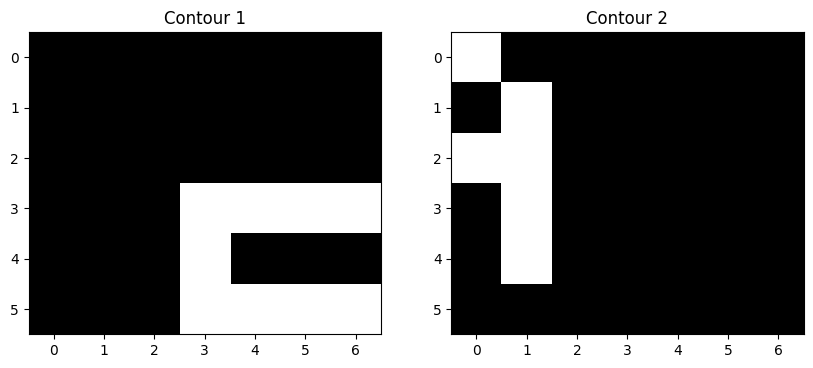

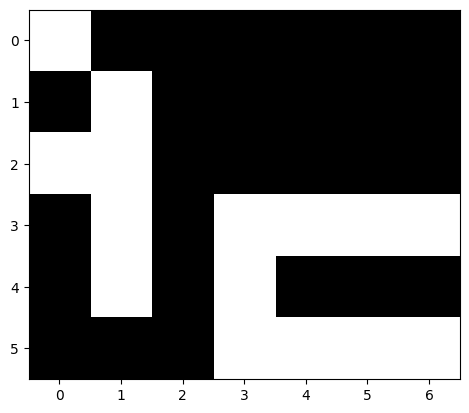

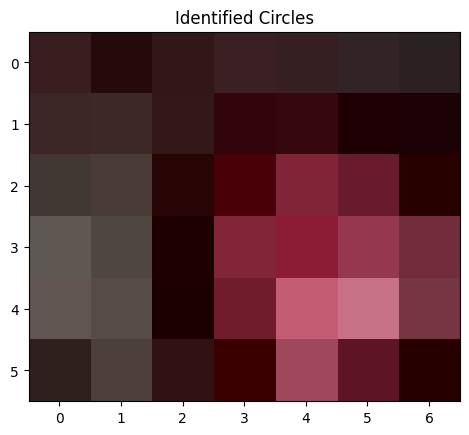

In [391]:
gray = cv2.cvtColor(left_iris, cv2.COLOR_BGR2GRAY)

# Perform edge detection
edges = cv2.Canny(gray, 50, 150)

# Find contours in the edged left_iris
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(len(contours))
plot_contours(contours)

for contour in contours:
    # Approximate the contour to a circle
    (x, y), radius = cv2.minEnclosingCircle(contour)
    center = (int(x), int(y))
    radius = int(radius)

    if radius > 10:  # Only consider larger circles
        # Draw the circle in the output left_iris
        cv2.circle(left_iris, center, radius, (0, 255, 0), 2)

        # Convert center coordinates to integers
        x = int(x)
        y = int(y)

        # Extract the color values of the circle
        red, green, blue = left_iris[y,x]

        # Check if the circle is red
        if red > 100 and green < 75 and blue < 75:
            print("Red eye detected at position:", x, y)
plt.imshow(cv2.cvtColor(left_iris, cv2.COLOR_BGR2RGB))
plt.title('Identified Circles')
plt.show()

## Hough Circles

None


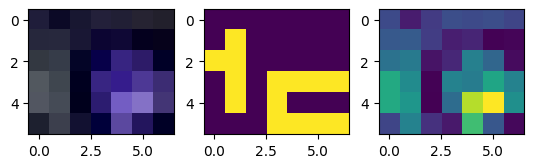

In [392]:
import numpy as np
plt.subplot(1,3,1)
plt.imshow(left_iris)
# Convert the image to grayscale
gray = cv2.cvtColor(left_iris, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, 150, 150)
plt.subplot(1,3,2)
plt.imshow(edges)

# Use HoughCircles to detect circles in the image
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1.2, 100)
print(circles)
if circles is not None:
    # Convert the circles to integers
    circles = np.round(circles[0, :]).astype("int")

    for (x, y, r) in circles:
        # Draw the circle in the output image
        cv2.circle(left_iris, (x, y), r, (0, 255, 0), 4)

        # Extract the color values of the circle
        red, green, blue = left_iris[y,x]

        # Check if the circle is red
        if red > 100 and green < 75 and blue < 75:
            print("Red eye detected at position:", x, y)

# Display the output left_iris
plt.subplot(1,3,3)
plt.imshow(gray)
plt.show()


# Extract Eyeball: Check eye is covered or not (Hair)

## Canny Edge Detection

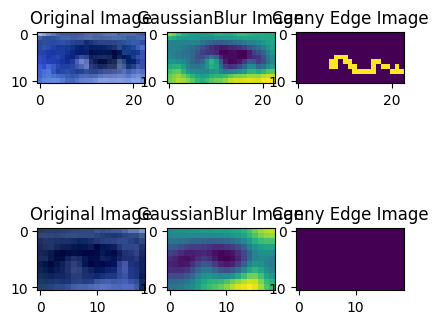

In [344]:
gray_roi = cv2.cvtColor(left_iris, cv2.COLOR_BGR2GRAY)
# _, threshold = cv2.threshold(gray_roi, 100, 101, cv2.THRESH_BINARY_INV)
gray_roi = cv2.GaussianBlur(gray_roi, (3, 3), 0)
left_iris_edges = cv2.Canny(gray_roi,80,250)

plt.subplot(2, 4, 1)
plt.imshow(left_iris)
plt.title('Original Image')
plt.subplot(2, 4, 2)
plt.imshow(gray_roi)
plt.title('GaussianBlur Image')
plt.subplot(2, 4, 3)
plt.imshow(left_iris_edges)
plt.title('Canny Edge Image')
# plt.subplot(2, 4, 4)
# plt.imshow(threshold)
# plt.title('Threshold Image')

gray_roi = cv2.cvtColor(right_iris, cv2.COLOR_BGR2GRAY)
gray_roi = cv2.GaussianBlur(gray_roi, (7, 7), 0)
right_iris_edges = cv2.Canny(gray_roi,80,250)

plt.subplot(2, 4, 5)
plt.imshow(right_iris)
plt.title('Original Image')
plt.subplot(2, 4, 6)
plt.imshow(gray_roi)
plt.title('GaussianBlur Image')
plt.subplot(2, 4, 7)
plt.imshow(right_iris_edges)
plt.title('Canny Edge Image')

plt.show()


In [313]:
contours, _ = cv2.findContours(left_iris_edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
# If no contours were found, it means we didn't find an eye
if len(contours) == 0:
    print("No eye detected")
else:
    print("Eye detected")


plot_contours(contours)

6
Eye detected


## Hough Transform

In [136]:
import cv2
import numpy as np


gray = cv2.cvtColor(left_iris, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to the image
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform edge detection
edges = cv2.Canny(gray, 50, 150)

# Perform a dilation and erosion to close gaps in between object edges
edges = cv2.dilate(edges, None, iterations=2)
edges = cv2.erode(edges, None, iterations=1)

# Perform Hough Transform to detect circles
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100)
print(circles)
# Ensure at least some circles were found
if circles is not None:
    # Convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles[0, :]).astype("int")

    # Loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circles:
        # Draw the circle in the output image
        cv2.circle(left_iris, (x, y), r, (0, 255, 0), 4)

    # Show the output left_iris
    cv2.imshow("Image", left_iris)
    cv2.waitKey(0)


None


## Watershed algorithm

[ WARN:0@15368.113] global loadsave.cpp:248 findDecoder imread_('eye_image.jpg'): can't open/read file: check file path/integrity


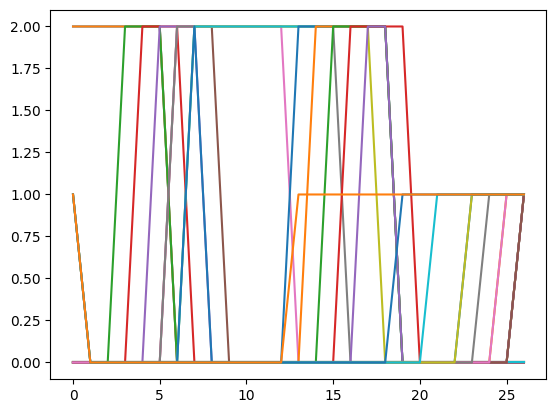

error: OpenCV(4.8.0) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/segmentation.cpp:161: error: (-215:Assertion failed) src.type() == CV_8UC3 && dst.type() == CV_32SC1 in function 'watershed'


In [137]:
import cv2
import numpy as np

# Load the image
image = cv2.imread('eye_image.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(left_iris, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding to the grayscale image
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal (optional)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# Determine the area which we are sure of being the background
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Determine the area which we are sure of being the object
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
_, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Subtract the two images to get the region of interest
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.plot(markers)
plt.show()

# Apply watershed algorithm
markers = cv2.watershed(image, markers)
image[markers == -1] = [255,0,0]

cv2.imshow('Output', image)
cv2.waitKey(0)
cv2.destroyAllWindows()
